In [137]:
import pandas as pd
from glob import glob
import numpy as np
import os
import time

import xgboost as xgb
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit

import matplotlib.pyplot as plt

## Set random seed
seed = 42
np.random.seed(seed) 


## Load and Processing Data

In [52]:
def read_and_processing_data(path):
    df = pd.read_csv(path)
    
    # Preprocess timestamps
    df['COLLECTION_TIME'] = pd.to_datetime(df['COLLECTION_TIME'])
    df.set_index('COLLECTION_TIME', inplace=True)

    # Define the resampling interval
    resample_interval = '1000L'  

    # Compute the mid-price using the best bid and ask prices
    df['mid_price'] = (df['BID_PRICE_1'] + df['ASK_PRICE_1']) / 2

    # Compute the spread
    df['spread'] = df['ASK_PRICE_1'] - df['BID_PRICE_1']

    # List of bid and ask size column names
    bid_size_cols = [f'BID_SIZE_{i}' for i in range(1, 12)]
    ask_size_cols = [f'ASK_SIZE_{i}' for i in range(1, 12)]

    # Compute total bid and ask sizes
    df['total_bid_size'] = df[bid_size_cols].sum(axis=1)
    df['total_ask_size'] = df[ask_size_cols].sum(axis=1)

    # Compute order book imbalance
    epsilon = 1e-10  # Small constant to prevent division by zero
    df['ob_imbalance'] = (df['total_bid_size'] - df['total_ask_size']) / (df['total_bid_size'] + df['total_ask_size'] + epsilon)
    
    return df
    

## Feature Engineering
Since we are implementing a baseline with classical machine-learning models, i.e. XGBoost, those models are dealing with static features not temporal ones. We need to do the feature enginnering:
1. Calculathe OLHC, order imbalance, spread, average total size in a sampling window, i.e. window size = 0.1s
2. Calculate the rolling mean, sd, min/max with a rolling window of 5 steps
3. Lagged features (last closed price)
4. Technical indicators including Exponential Moving Averages (EMA), Relative Strength Index (RSI) and Moving Average Convergence Divergence (MACD)

In [93]:
def feature_engineering(df):
    # Resample and compute OHLC features
    candlestick_df = pd.DataFrame()
    candlestick_df['open'] = df['mid_price'].resample(resample_interval).first()
    candlestick_df['high'] = df['mid_price'].resample(resample_interval).max()
    candlestick_df['low'] = df['mid_price'].resample(resample_interval).min()
    candlestick_df['close'] = df['mid_price'].resample(resample_interval).last()

    # Compute additional features by resampling
    candlestick_df['avg_total_size'] = (df['total_bid_size'] + df['total_ask_size']).resample(resample_interval).mean()
    candlestick_df['spread'] = df['spread'].resample(resample_interval).mean()
    candlestick_df['ob_imbalance'] = df['ob_imbalance'].resample(resample_interval).mean()

    # Forward-fill any missing values
    candlestick_df.fillna(method='ffill', inplace=True)

    # Calculate Rolling Statistics
    rolling_window = 20  # Adjust as needed

    # Rolling statistics for 'close' price
    candlestick_df['rolling_mean'] = candlestick_df['close'].rolling(window=rolling_window).mean()
    candlestick_df['rolling_std'] = candlestick_df['close'].rolling(window=rolling_window).std()
    candlestick_df['rolling_min'] = candlestick_df['close'].rolling(window=rolling_window).min()
    candlestick_df['rolling_max'] = candlestick_df['close'].rolling(window=rolling_window).max()

    # Rolling statistics for 'spread'
    candlestick_df['rolling_spread_mean'] = candlestick_df['spread'].rolling(window=rolling_window).mean()
    candlestick_df['rolling_spread_std'] = candlestick_df['spread'].rolling(window=rolling_window).std()

    # Rolling statistics for 'ob_imbalance'
    candlestick_df['rolling_ob_imbalance_mean'] = candlestick_df['ob_imbalance'].rolling(window=rolling_window).mean()
    candlestick_df['rolling_ob_imbalance_std'] = candlestick_df['ob_imbalance'].rolling(window=rolling_window).std()

    # Add Lagged Variables (e.g., previous close prices)
    lag_periods = 3  # Number of lagged periods
    for lag in range(1, lag_periods + 1):
        candlestick_df[f'lag_close_{lag}'] = candlestick_df['close'].shift(lag)


    # Calculate Exponential Moving Averages (EMA)
    ema_spans = [3, 5, 8]  # EMA periods
    for span in ema_spans:
        candlestick_df[f'ema_close_{span}'] = candlestick_df['close'].ewm(span=span, adjust=False).mean()

    # Calculate Relative Strength Index (RSI)
    window_length = 20
    delta = candlestick_df['close'].diff()
    gain = (delta.where(delta > 0, 0)).fillna(0)
    loss = (-delta.where(delta < 0, 0)).fillna(0)
    avg_gain = gain.rolling(window=window_length).mean()
    avg_loss = loss.rolling(window=window_length).mean()
    rs = avg_gain / (avg_loss + epsilon)
    candlestick_df['rsi'] = 100 - (100 / (1 + rs))

    # Calculate Moving Average Convergence Divergence (MACD)
    ema_5 = candlestick_df['close'].ewm(span=5, adjust=False).mean()
    ema_10 = candlestick_df['close'].ewm(span=10, adjust=False).mean()
    candlestick_df['macd'] = ema_5 - ema_10
    candlestick_df['macd_signal'] = candlestick_df['macd'].ewm(span=9, adjust=False).mean()
    candlestick_df['macd_hist'] = candlestick_df['macd'] - candlestick_df['macd_signal']

    # Drop initial rows with NaN values from rolling calculations and indicators
    candlestick_df.dropna(inplace=True)

    # Reset index to make 'timestamp' a column again
    candlestick_df.reset_index(inplace=True)

    # Define the target variable: future close price
    forecast_horizon = 1  # Number of periods ahead to predict
    candlestick_df['future_close'] = candlestick_df['close'].shift(-forecast_horizon)

    # Drop the last rows with NaN in 'future_close'
    candlestick_df.dropna(inplace=True)

    # Feature columns
    feature_columns = [
        'open', 'high', 'low', 'close', 'avg_total_size', 'spread', 'ob_imbalance',
        'rolling_mean', 'rolling_std', 'rolling_min', 'rolling_max',
        'rolling_spread_mean', 'rolling_spread_std',
        'rolling_ob_imbalance_mean', 'rolling_ob_imbalance_std',
        # Lagged variables
        'lag_close_1', 'lag_close_2', 'lag_close_3',
        # Exponential Moving Averages
        'ema_close_3', 'ema_close_5', 'ema_close_8',
        # Technical Indicators
        'rsi', 'macd', 'macd_signal', 'macd_hist'
    ]

    # Define features (X) and target (y)
    X = candlestick_df[feature_columns]
    y = candlestick_df['future_close']
    time_stamps = candlestick_df['COLLECTION_TIME'].values
    
    return X, y, time_stamps

## Fit the Model - XGBoost

In [126]:
# Split the data into train and test, where the first 6-day data are training, the last data is for testing/evaluation

all_files = sorted(glob('../data/*book_updates.csv'))

X_train = []
y_train = []
train_time_stamps = []

for file in all_files[:-1]:
    df = read_and_processing_data(file)
    X, y, time_stamps = feature_engineering(df)
    X_train.append(X)
    y_train.append(y)
    train_time_stamps.append(time_stamps)

X_train = np.concatenate(X_train, axis=0)
y_train = np.concatenate(y_train, axis=0)
train_time_stamps = np.concatenate(train_time_stamps, axis=0)

test_df = read_and_processing_data(all_files[-1])
X_test, y_test, test_time_stamps = feature_engineering(test_df)

/tmp/ipykernel_3889909/39924893.py:4: FutureWarning: 'L' is deprecated and will be removed in a future version, please use 'ms' instead.
  candlestick_df['open'] = df['mid_price'].resample(resample_interval).first()
/tmp/ipykernel_3889909/39924893.py:5: FutureWarning: 'L' is deprecated and will be removed in a future version, please use 'ms' instead.
  candlestick_df['high'] = df['mid_price'].resample(resample_interval).max()
/tmp/ipykernel_3889909/39924893.py:6: FutureWarning: 'L' is deprecated and will be removed in a future version, please use 'ms' instead.
  candlestick_df['low'] = df['mid_price'].resample(resample_interval).min()
/tmp/ipykernel_3889909/39924893.py:7: FutureWarning: 'L' is deprecated and will be removed in a future version, please use 'ms' instead.
  candlestick_df['close'] = df['mid_price'].resample(resample_interval).last()
/tmp/ipykernel_3889909/39924893.py:10: FutureWarning: 'L' is deprecated and will be removed in a future version, please use 'ms' instead.
  c

In [138]:
start_time = time.time()

## Grid search to find the optimal parameters
param_grid = {
    'n_estimators': [500, 1000],
    'max_depth': [9, 15, 20],
    'learning_rate': [0.01, 0.02, 0.04],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.8],
    'gamma': [0.1],
    'reg_lambda': [1, 1.5, 2],
}

xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_grid,
    n_iter=10,  # Number of parameter settings sampled
    scoring='neg_mean_squared_error',
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1
)

random_search.fit(X_train, y_train)

# Train the final model with best parameters
best_model = random_search.best_estimator_

# Make predictions on the test set
y_pred = best_model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2_score = best_model.score(X_test, y_test)
print(f"Test Mean Squared Error: {mse}")
print(f"Test R^2 Score: {r2_score}")

best_model.save_model("best_xgb_model.json")

train_time = time.time() - start_time
print(f"The total training takes: {train_time:.4f} seconds")


Test Mean Squared Error: 0.042810633929717644
Test R^2 Score: 0.8575341446992553
The total training takes: 161.9577 seconds


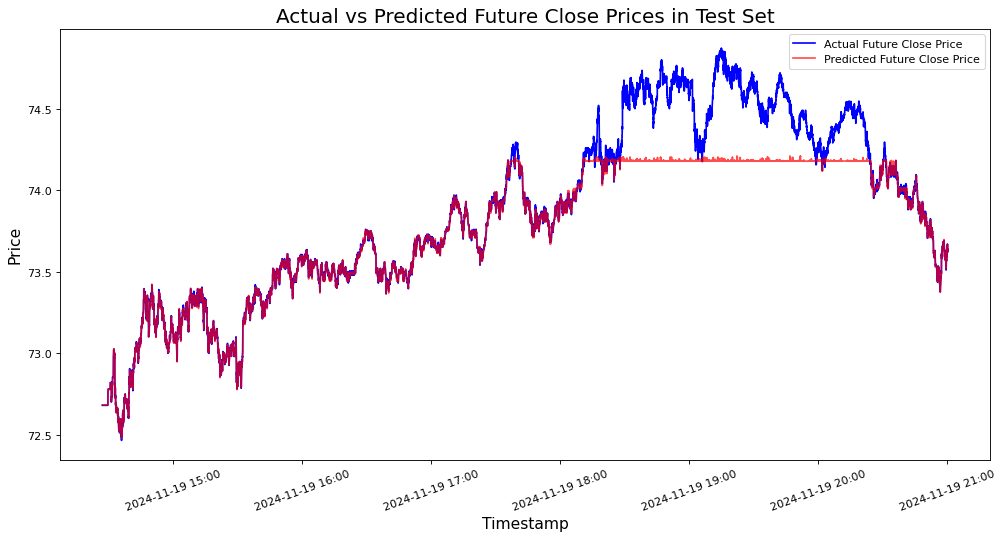

In [142]:
# Plot the predicted prices vs actual prices
plt.figure(figsize=(15, 7), dpi=80)
plt.plot(test_time_stamps, y_test, label='Actual Future Close Price', color='blue')
plt.plot(test_time_stamps, y_pred, label='Predicted Future Close Price', color='red', alpha=0.7)
plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter('%Y-%m-%d %H:%M'))
plt.gca().xaxis.set_major_locator(plt.matplotlib.dates.AutoDateLocator())
plt.xticks(rotation=20)
plt.xlabel('Timestamp', fontsize=14)
plt.ylabel('Price', fontsize=14)
plt.title('Actual vs Predicted Future Close Prices in Test Set', fontsize=18)
plt.legend()
plt.show()

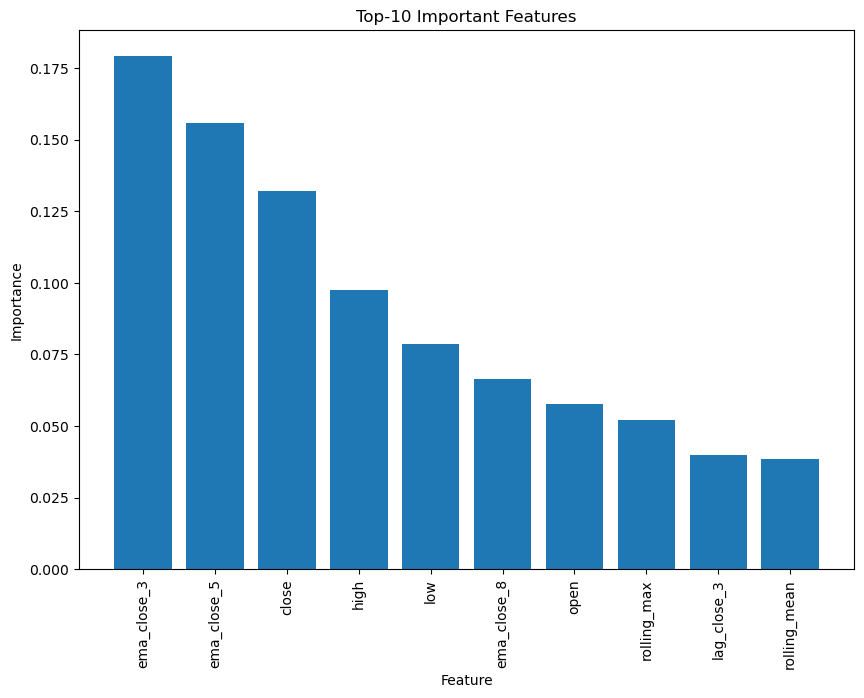

In [104]:
# Plot feature importance
plt.figure(figsize=(10, 7))
plt.bar(range(len(sorted_idx[:10])), feature_importances[sorted_idx[:10]])
plt.xticks(range(len(sorted_idx[:10])), np.array(feature_columns)[sorted_idx[:10]], rotation=90)
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.title("Top-10 Important Features")
plt.show()

In [136]:
# Calculate the inference time
start_time = time.time()
y_pred = best_model.predict(X_test.iloc[[0]])
inference_time = time.time() - start_time
print(f"Single-entry Inference time: {inference_time:.4f} seconds")

# Calculate the inference time
start_time = time.time()
y_pred = best_model.predict(X_test.iloc[0:10000])
inference_time = time.time() - start_time
print(f"Inference time of 10,000 data: {inference_time:.4f} seconds")

Single-entry Inference time: 0.0135 seconds
Inference time of 10,000 data: 0.0308 seconds


## Investigation: Why the model has a terrible performance at price > 74

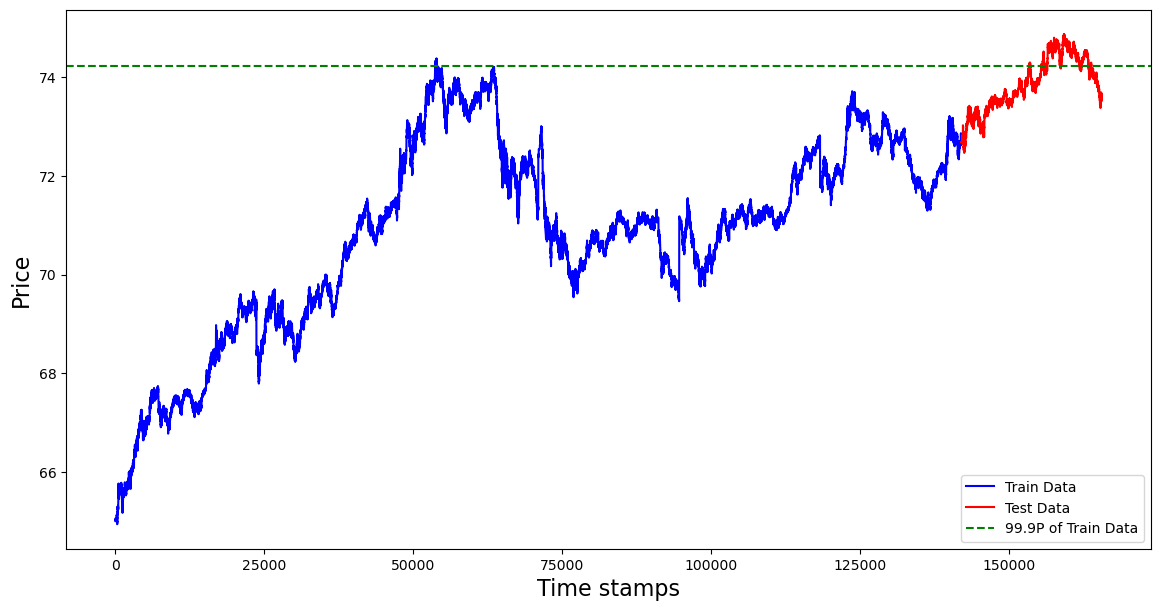

In [146]:
# Any advanced ML model could not predict a value that it has never seen. (Some may claim it could, but the well...)
# In the test data, we can see those bad performance occur when the prices exceeed the 99.95 percentile of the prices in
# training data. This is totally expected and that's why we need to keep updating our model.

plt.figure(figsize=(14, 7))

x1 = np.arange(len(y_train))             
x2 = np.arange(len(y_train), len(y_train) + len(y_test))  

# Plot the two datasets with different colors
plt.plot(x1, y_train, label='Train Data', color='blue')  
plt.plot(x2, y_test, label='Test Data', color='red')  
plt.ylabel('Price', fontsize=16)
plt.xlabel('Time stamps', fontsize=16)

plt.axhline(y=np.percentile(y_train, 99.9), color='green', linestyle='--', label='99.9P of Train Data')
plt.legend()